<a href="https://colab.research.google.com/github/ZEmRX-0/NLP_Project/blob/main/NLP_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!wget -P /content/ https://github.com/ZEmRX-0/NLP_Project/raw/main/Train.xls
!pip install accelerate -U

--2024-03-19 04:07:10--  https://github.com/ZEmRX-0/NLP_Project/raw/main/Train.xls
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ZEmRX-0/NLP_Project/main/Train.xls [following]
--2024-03-19 04:07:11--  https://raw.githubusercontent.com/ZEmRX-0/NLP_Project/main/Train.xls
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21695488 (21M) [application/octet-stream]
Saving to: ‘/content/Train.xls.2’

Train.xls.2         100%[===================>]  20.69M  49.8MB/s    in 0.4s    

2024-03-19 04:07:12 (49.8 MB/s) - ‘/content/Train.xls.2’ saved [21695488/21695488]



In [2]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset


In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
ROOT_DIR = '/content/'

df= pd.read_excel(ROOT_DIR + "Train.xls")

df= df.sample(frac=1.0, random_state=42)

df.head()

,PhraseId,Phrase,Sentiment
19756,19757,I’m stuckI can’t get professional help and I f...,3
2240,2241,"oh boy, where to start! i guess my biggest str...",0
20681,20682,Is it possible I'm living a nightmare/in hellI...,3
3096,3097,work! we are short handed and so all the work ...,0
7840,7841,I GOT GOVERNMENT JOB\nFRIENDS MEETING\nFRIENDS...,1


In [5]:
value_to_name = {
    0: "Sadness",
    1: "Happiness",
    2: "Depression",
    3: "Suicide",
    4: "Neutral",
}

df["Sentiment_name"] = df["Sentiment"].map(value_to_name.get)


In [6]:
df.head()

,PhraseId,Phrase,Sentiment,Sentiment_name
19756,19757,I’m stuckI can’t get professional help and I f...,3,Suicide
2240,2241,"oh boy, where to start! i guess my biggest str...",0,Sadness
20681,20682,Is it possible I'm living a nightmare/in hellI...,3,Suicide
3096,3097,work! we are short handed and so all the work ...,0,Sadness
7840,7841,I GOT GOVERNMENT JOB\nFRIENDS MEETING\nFRIENDS...,1,Happiness


In [7]:
labels = df['Sentiment_name'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['Suicide', 'Sadness', 'Happiness', 'Depression', 'Neutral']

In [8]:
for key, value in enumerate(labels):
    print(value)

Suicide
Sadness
Happiness
Depression
Neutral


In [9]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [10]:
label2id

{'Suicide': 0, 'Sadness': 1, 'Happiness': 2, 'Depression': 3, 'Neutral': 4}

In [11]:
id2label

{0: 'Suicide', 1: 'Sadness', 2: 'Happiness', 3: 'Depression', 4: 'Neutral'}

In [12]:
df.head()

,PhraseId,Phrase,Sentiment,Sentiment_name
19756,19757,I’m stuckI can’t get professional help and I f...,3,Suicide
2240,2241,"oh boy, where to start! i guess my biggest str...",0,Sadness
20681,20682,Is it possible I'm living a nightmare/in hellI...,3,Suicide
3096,3097,work! we are short handed and so all the work ...,0,Sadness
7840,7841,I GOT GOVERNMENT JOB\nFRIENDS MEETING\nFRIENDS...,1,Happiness


In [13]:
df["Sentiment"]=df.Sentiment_name.map(lambda x: label2id[str(x).strip()])

In [14]:
df.head()

,PhraseId,Phrase,Sentiment,Sentiment_name
19756,19757,I’m stuckI can’t get professional help and I f...,0,Suicide
2240,2241,"oh boy, where to start! i guess my biggest str...",1,Sadness
20681,20682,Is it possible I'm living a nightmare/in hellI...,0,Suicide
3096,3097,work! we are short handed and so all the work ...,1,Sadness
7840,7841,I GOT GOVERNMENT JOB\nFRIENDS MEETING\nFRIENDS...,2,Happiness


<Axes: >

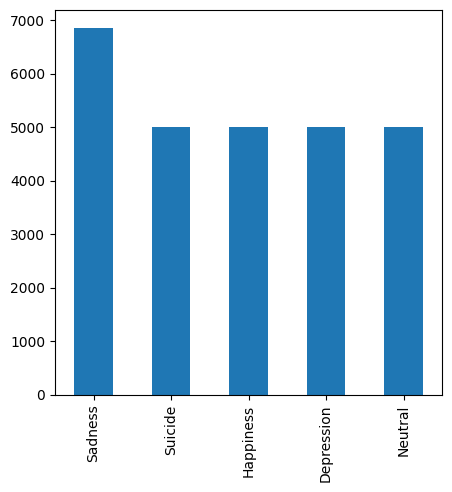

In [15]:
df.Sentiment_name.value_counts().plot(kind='bar', figsize=(5,5))

In [16]:
tokenizer = BertTokenizerFast.from_pretrained("google-bert/bert-base-uncased", max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [17]:
model = BertForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Splitting df عشان يجرب داتا من نفس الداتا سيت عشان يشوف الاكيورسي


In [18]:
SIZE= df.shape[0]

train_texts= list(df.Phrase[:SIZE//2])

val_texts=   list(df.Phrase[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df.Phrase[(3*SIZE)//4:])

train_labels= list(df.Sentiment[:SIZE//2])

val_labels=   list(df.Sentiment[SIZE//2:(3*SIZE)//4])

test_labels=  list(df.Sentiment[(3*SIZE)//4:])

In [19]:
len(train_texts)


13424

In [20]:
len(train_texts), len(val_texts), len(test_texts)

(13424, 6712, 6712)

In [21]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [22]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [23]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

## Training

In [24]:
from transformers import TrainingArguments, Trainer

In [25]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }


In [28]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./model',  # Adjusted to a relative path
    do_train=True,
    do_eval=True,
    # The number of epochs, defaults to 3.0
    num_train_epochs=2,  # Reduced to 2 epochs to save time
    per_device_train_batch_size=8,  # Reduced batch size to save memory
    per_device_eval_batch_size=8,   # Reduced batch size to save memory
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='epoch',
    # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=100,  # Adjusted logging steps to reduce output
    evaluation_strategy="epoch",
    eval_steps=100,  # Adjusted evaluation steps to reduce evaluation frequency
    save_strategy="epoch",  # Save model checkpoints after each epoch
    save_total_limit=1,  # Limit the number of saved checkpoints to save disk space
    load_best_model_at_end=True,
    disable_tqdm=True,  # Disable tqdm progress bars to improve performance
)




In [29]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

In [ ]:
q=[trainer.evaluate(eval_dataset=df) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast


In [ ]:
def predict(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label


In [ ]:
text = "make me a sandwich."
predict(text)

## Save model for inference

In [ ]:
model_path = "sentemintal_anal_model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

## Re-Load saved model for inference

In [ ]:
model_path = "sentemintal_anal_model"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [ ]:
nlp("make me a sandwich")